<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [846]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [847]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20172257" #@param {type:"string"}
Student_full_name = "Stephen Quirke" #@param {type:"string"}
#@markdown ---

In [848]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

# Task

You have to create a  piecewise regression model following the guidelines from the notebook provided to predict the house price using the provided dataset in the GitHub repository.

1. Get the dataset: train, test, and true price.
2. Analyse the dataset and decide what features to use.
3. Clean the dataset: remove nan's and possible outliers.
4. You could remove registers with 0 bathrooms and 0 bedrooms.
5. Your goal is to use a piecewise regression to solve this problem.
6. Follow the guidelines from the example provided.
7. Apply a full model first as a baseline.
8. You could select longitude and latitude to create clusters.
9. Use the number of clusters you model returns.
10. Apply a model to each cluster.
11. Analyse the results and give a comparison from both approaches
12. You could split the training to get a validation dataset.
13. Take notes from all the experiment results and bring your insights in your summary.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [849]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [850]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
import os
from sklearn.preprocessing import StandardScaler

In [851]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [852]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# 1. DATASET (Get the dataset: train, test, and true price.)

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [853]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [854]:
dftrain = pd.read_csv(os.path.join("/content/drive/MyDrive/Colab Notebooks/ET5003_Etivity2/","house_train.csv"))
dftest = pd.read_csv(os.path.join("/content/drive/MyDrive/Colab Notebooks/ET5003_Etivity2/","house_test.csv"))
dfcost = pd.read_csv(os.path.join("/content/drive/MyDrive/Colab Notebooks/ET5003_Etivity2/","true_price.csv"))

In [855]:
print("Training Data:", dftrain.shape)
print("Test Data:", dftest.shape)
print("Cost Data:", dfcost.shape)

Training Data: (2982, 17)
Test Data: (500, 16)
Cost Data: (500, 2)


In [856]:
print(dftrain.head(5))

     ad_id         area  ...  property_type  surface
0   996887  Portmarnock  ...            NaN      NaN
1   999327        Lucan  ...            NaN      NaN
2   999559  Rathfarnham  ...            NaN      NaN
3  9102986   Balbriggan  ...            NaN      NaN
4  9106028      Foxrock  ...            NaN      NaN

[5 rows x 17 columns]


In [857]:
print(f"Training/Test Data Split: {round((500/2982)*100)}%")

Training/Test Data Split: 17%


### Commentary:
There is roughly a 83:17 split of training and test data. Let's add them together and split it 70:30. We have already ingested the training data which is 2982 rows plus the test data which is 500 rows plus the true house price for the the test data.

# 2. Analyse the dataset and decide what features to use.

### Train dataset

In [858]:
#Generate descriptive statistics
dftrain.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


Show first data frame rows 

In [859]:
dftrain.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [860]:
dftrain['county'].value_counts()

Dublin    2982
Name: county, dtype: int64

In [861]:
dftrain['environment'].value_counts()

prod    2982
Name: environment, dtype: int64

### Test dataset

In [862]:
# Generate descriptive statistics
dftest.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


In [863]:
# show first data frame rows 
dftest.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


### Expected Cost dataset

In [864]:
# Generate descriptive statistics
dfcost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


In [865]:
dfcost = dfcost.drop(columns='Id')
dfcost.shape

(500, 1)

In [866]:
dftest = pd.concat([dftest, dfcost], axis=1)

In [867]:
dftest.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,Expected
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0,875000.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0,355000.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0,440000.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4,425000.0
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0,265000.0


Rename the column name to cost instead of expected.

In [868]:
cost_data = [dftest['Expected']]
header_name = ['cost']
dfcost = pd.concat(cost_data, axis=1, keys=header_name)
dftest = pd.concat([dftest, dfcost], axis=1)
dftest.drop(columns='Expected', inplace=True)
dfcost.shape

(500, 1)

In [869]:
dftest.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,cost
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0,875000.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0,355000.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0,440000.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4,425000.0
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0,265000.0


In [870]:
# show first data frame rows 
dfcost.head()

,cost
0,875000.0
1,355000.0
2,440000.0
3,425000.0
4,265000.0


## Commentary:

After looking at the data, we will use all of the features except for the following:
*   ad_id (just an index and does not offer anything useful)
*   county (there is only one county which is Dublin)
*   description_block (free text, won't give specific details and subjective)
*   environment (not clear what this is, maybe the app environment but either way there is only one value which is prod. This gives us no information)
*   facility (Free text, won't give specific details and subjective)
*   features (Free text, won't give specific details and subjective)







In [871]:
dftrain_copy = dftrain
dftest_copy = dftest
dfcost_copy = dfcost

In [872]:
dftrain = dftrain.drop(columns=['ad_id', 'county', 'description_block', 'environment', 'facility', 'features'])
dftest = dftest.drop(columns=['ad_id', 'county', 'description_block', 'environment', 'facility', 'features'])

# 3. Clean the dataset: remove nan's and possible outliers.

### Train dataset

In [873]:
column_list = ['area','bathrooms','beds','ber_classification','latitude','longitude','no_of_units','property_category','property_type','surface']
print(column_list)

['area', 'bathrooms', 'beds', 'ber_classification', 'latitude', 'longitude', 'no_of_units', 'property_category', 'property_type', 'surface']


In [874]:
for col in column_list:
  print(f"Missing {col} data:", dftrain[col].isna().sum())

Missing area data: 0
Missing bathrooms data: 51
Missing beds data: 51
Missing ber_classification data: 677
Missing latitude data: 0
Missing longitude data: 0
Missing no_of_units data: 2923
Missing property_category data: 0
Missing property_type data: 51
Missing surface data: 551


In [875]:
# Percentage of missing data
for col in column_list:
  print(f"Missing {col} data:", str(round(((dftrain[col].isna().sum()/2931)*100),2))+ '%')

Missing area data: 0.0%
Missing bathrooms data: 1.74%
Missing beds data: 1.74%
Missing ber_classification data: 23.1%
Missing latitude data: 0.0%
Missing longitude data: 0.0%
Missing no_of_units data: 99.73%
Missing property_category data: 0.0%
Missing property_type data: 1.74%
Missing surface data: 18.8%


In [876]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area                2982 non-null   object 
 1   bathrooms           2931 non-null   float64
 2   beds                2931 non-null   float64
 3   ber_classification  2305 non-null   object 
 4   latitude            2982 non-null   float64
 5   longitude           2982 non-null   float64
 6   no_of_units         59 non-null     float64
 7   price               2892 non-null   float64
 8   property_category   2982 non-null   object 
 9   property_type       2931 non-null   object 
 10  surface             2431 non-null   float64
dtypes: float64(7), object(4)
memory usage: 256.4+ KB


### Test dataset

In [877]:
for col in column_list:
  print(f"Missing {col} data:", str(round(((dftest[col].isna().sum()/2931)*100),2))+ '%')

Missing area data: 0.0%
Missing bathrooms data: 0.0%
Missing beds data: 0.0%
Missing ber_classification data: 1.91%
Missing latitude data: 0.0%
Missing longitude data: 0.0%
Missing no_of_units data: 17.06%
Missing property_category data: 0.0%
Missing property_type data: 0.0%
Missing surface data: 0.0%


In [878]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area                500 non-null    object 
 1   bathrooms           500 non-null    float64
 2   beds                500 non-null    float64
 3   ber_classification  444 non-null    object 
 4   latitude            500 non-null    float64
 5   longitude           500 non-null    float64
 6   no_of_units         0 non-null      float64
 7   property_category   500 non-null    object 
 8   property_type       500 non-null    object 
 9   surface             500 non-null    float64
 10  cost                500 non-null    float64
dtypes: float64(7), object(4)
memory usage: 43.1+ KB


## Commentary:

We get a count of missing data for the following columns that will require treatment:
*    bathrooms data: 51 (1.74%)
*    beds data: 51 (1.74%)
*    ber_classification data: 677 (23.1%)
*    no_of_units data: 2923 (99.73%)
*    property_type data: 51 (1.74%)
*    surface data: 551 (18.8%)

There is no value for units of data, so we can drop this column. There is different methods we can use to treat the other columns based on the number of missing columns but for simplicity we will delete any column with a missing value.

We will also delete "No of units" as we have no data for this column in the test data set.

Drop NA columns. Drop no_of_units first as this will delete 99.73% fo the rows

In [879]:
dftrain = dftrain.drop(columns=['no_of_units'])
dftrain.dropna(inplace=True)
dftrain.shape

(2002, 10)

In [880]:
dftest = dftest.drop(columns=['no_of_units'])
dftest.dropna(inplace=True)
dftest.shape

(444, 10)

In [881]:
dftest.head(5)

,area,bathrooms,beds,ber_classification,latitude,longitude,property_category,property_type,surface,cost
0,Skerries,2.0,4.0,G,53.566881,-6.101148,sale,bungalow,142.0,875000.0
1,Lucan,2.0,3.0,C1,53.362992,-6.452909,sale,terraced,114.0,355000.0
2,Swords,3.0,4.0,B3,53.454198,-6.262964,sale,semi-detached,172.0,440000.0
3,Lucan,4.0,3.0,A3,53.354402,-6.458647,sale,semi-detached,132.4,425000.0
4,Clondalkin,1.0,3.0,E2,53.336530,-6.393587,sale,semi-detached,88.0,265000.0


# 4. You could remove registers with 0 bathrooms and 0 bedrooms.

In [882]:
#Drop Bathrooms and Beds that are equal to 0
dftrain.drop(dftrain[dftrain.beds == 0].index, inplace=True)
dftrain.drop(dftrain[dftrain.bathrooms == 0].index, inplace=True)
dftrain.shape

(1989, 10)

# 5. Your goal is to use a piecewise regression to solve this problem.

## Commentary

Before we execute the piecewise regression model on the data, we will examine the data and encode categorical data appropriately

In [883]:
dftrain['area'].value_counts()

Rathfarnham      73
Castleknock      67
Malahide         57
Lucan            55
Blackrock        51
                 ..
Edenmore          1
Ard Na Greine     1
Greenhills        1
Kilmore           1
Ballybough        1
Name: area, Length: 144, dtype: int64

In [884]:
dftrain['ber_classification'].value_counts()

D1                     255
D2                     241
C3                     224
C2                     210
C1                     182
E1                     154
E2                     148
G                      144
F                      135
B3                     106
B2                      69
A3                      61
SINo666of2006exempt     23
A2                      22
B1                      14
A1                       1
Name: ber_classification, dtype: int64

In [885]:
dftest['ber_classification'].value_counts()

D1                     63
C2                     54
C3                     48
C1                     44
D2                     43
G                      37
E1                     33
F                      32
E2                     28
B3                     25
B2                     14
A3                      9
A2                      6
SINo666of2006exempt     5
B1                      3
Name: ber_classification, dtype: int64

In [886]:
dftrain['property_category'].value_counts()

sale                      1983
new_development_parent       6
Name: property_category, dtype: int64

In [887]:
dftest['property_category'].value_counts()

sale    444
Name: property_category, dtype: int64

## Commentary:

We will drop property category because we only have one value which is sale in the test data meaning it offers no value

In [888]:
dftrain = dftrain.drop(columns=['property_category'])
dftrain.dropna(inplace=True)
dftrain.shape

(1989, 9)

In [889]:
dftest = dftest.drop(columns=['property_category'])
dftest.dropna(inplace=True)
dftest.shape

(444, 9)

In [890]:
dftrain['property_type'].value_counts()

semi-detached     554
apartment         530
terraced          339
detached          297
end-of-terrace    153
bungalow           56
duplex             37
townhouse          19
site                3
studio              1
Name: property_type, dtype: int64

In [891]:
dftest['property_type'].value_counts()

semi-detached     126
apartment         120
terraced           80
detached           64
end-of-terrace     28
bungalow           12
duplex              8
townhouse           4
site                1
studio              1
Name: property_type, dtype: int64

After analysing the data, we are left with the following columns

In [892]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1989 entries, 15 to 2981
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area                1989 non-null   object 
 1   bathrooms           1989 non-null   float64
 2   beds                1989 non-null   float64
 3   ber_classification  1989 non-null   object 
 4   latitude            1989 non-null   float64
 5   longitude           1989 non-null   float64
 6   price               1989 non-null   float64
 7   property_type       1989 non-null   object 
 8   surface             1989 non-null   float64
dtypes: float64(6), object(3)
memory usage: 155.4+ KB


In [893]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 0 to 499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area                444 non-null    object 
 1   bathrooms           444 non-null    float64
 2   beds                444 non-null    float64
 3   ber_classification  444 non-null    object 
 4   latitude            444 non-null    float64
 5   longitude           444 non-null    float64
 6   property_type       444 non-null    object 
 7   surface             444 non-null    float64
 8   cost                444 non-null    float64
dtypes: float64(6), object(3)
memory usage: 34.7+ KB


# 6. Follow the guidelines from the example provided.

Create a mapper for the different areas in order to convert to a numeric value. One hot encoding is not suitable as there is 144 distinct areas.

In [802]:
labels = dftrain['area'].astype('category').cat.categories.tolist()
replace_map_comp_1 = {'area' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
dftrain.replace(replace_map_comp_1, inplace=True)

{'area': {'Adamstown': 1, 'Ard Na Greine': 2, 'Artane': 3, 'Ashtown': 4, 'Balbriggan': 5, 'Baldoyle': 6, 'Balgriffin': 7, 'Ballinteer': 8, 'Ballsbridge': 9, 'Ballybough': 10, 'Ballyboughal': 11, 'Ballybrack': 12, 'Ballycullen': 13, 'Ballyfermot': 14, 'Ballymun': 15, 'Balrothery': 16, 'Beaumont': 17, 'Blackrock': 18, 'Blanchardstown': 19, 'Bluebell': 20, 'Booterstown': 21, 'Brittas': 22, 'Cabinteely': 23, 'Cabra': 24, 'Carrickmines': 25, 'Castleknock': 26, 'Chapelizod': 27, 'Christchurch': 28, 'Churchtown': 29, 'Citywest': 30, 'Clarehall': 31, 'Clondalkin': 32, 'Clonee': 33, 'Clongriffin': 34, 'Clonshaugh': 35, 'Clonsilla': 36, 'Clonskeagh': 37, 'Clontarf': 38, 'Coolock': 39, 'Crumlin': 40, 'Dalkey': 41, 'Darndale': 42, 'Dartry': 43, 'Donabate': 44, 'Donaghmede': 45, 'Donnybrook': 46, 'Donnycarney': 47, 'Drimnagh': 48, 'Drumcondra': 49, 'Dublin 1': 50, 'Dublin 2': 51, 'Dublin 4': 52, 'Dublin 7': 53, 'Dublin 8': 54, 'Dun Laoghaire': 55, 'Dundrum': 56, 'East Wall': 57, 'Edenmore': 58, 'Fa

In [803]:
labels = dftest['area'].astype('category').cat.categories.tolist()
replace_map_comp_1 = {'area' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
dftest.replace(replace_map_comp_1, inplace=True)

{'area': {'Artane': 1, 'Ashtown': 2, 'Balbriggan': 3, 'Baldoyle': 4, 'Balgriffin': 5, 'Ballinteer': 6, 'Ballsbridge': 7, 'Ballybrack': 8, 'Ballycullen': 9, 'Ballymun': 10, 'Balrothery': 11, 'Beaumont': 12, 'Blackrock': 13, 'Blanchardstown': 14, 'Bluebell': 15, 'Booterstown': 16, 'Cabinteely': 17, 'Cabra': 18, 'Carrickmines': 19, 'Castleknock': 20, 'Chapelizod': 21, 'Christchurch': 22, 'Churchtown': 23, 'Clondalkin': 24, 'Clonee': 25, 'Clonsilla': 26, 'Clonskeagh': 27, 'Clontarf': 28, 'Crumlin': 29, 'Dalkey': 30, 'Dartry': 31, 'Deansgrange': 32, 'Donabate': 33, 'Donaghmede': 34, 'Donnybrook': 35, 'Donnycarney': 36, 'Drimnagh': 37, 'Drumcondra': 38, 'Dublin 1': 39, 'Dublin 2': 40, 'Dublin 4': 41, 'Dublin 7': 42, 'Dublin 8': 43, 'Dun Laoghaire': 44, 'Dundrum': 45, 'East Wall': 46, 'Fairview': 47, 'Finglas': 48, 'Firhouse': 49, 'Foxrock': 50, 'Garristown': 51, 'Glasnevin': 52, 'Glenageary': 53, 'Goatstown': 54, 'Grand Canal Dock': 55, "Harold's Cross": 56, 'Howth': 57, 'Inchicore': 58, 'Is

In [804]:
pip install category_encoders

In [805]:
import category_encoders as ce

# create object of Ordinalencoding
encoder = ce.OrdinalEncoder(cols=['ber_classification'],return_df=True, mapping=[{'col':'ber_classification', 
                                                                     'mapping':{'A1':0,
                                                                                'A2':1,
                                                                                'A3':2,
                                                                                'B1':3,
                                                                                'B2':4,
                                                                                'B3':5,
                                                                                'C1':6,
                                                                                'C2':7,
                                                                                'C3':8,
                                                                                'D1':9,
                                                                                'D2':10,
                                                                                'E1':11,
                                                                                'E2':12,
                                                                                'F':13,
                                                                                'G':14,
                                                                                'SINo666of2006exempt':15}}])


In [806]:
#fit and transform train & test data 
dftrain = encoder.fit_transform(dftrain)
dftest = encoder.fit_transform(dftest)

In [807]:
dftrain.shape

(1989, 9)

In [808]:
dftest.shape

(444, 9)

In [809]:
# One Hot Encoding
dftrain = pd.get_dummies(dftrain, columns = ["property_type"])
dftest= pd.get_dummies(dftest, columns = ["property_type"])

In [810]:
dftrain.head(5)

,area,bathrooms,beds,ber_classification,latitude,longitude,price,surface,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
15,33,3.0,5.0,2,53.400454,-6.445730,935000.0,321.0,0,0,1,0,0,0,0,0,0,0
26,32,4.0,4.0,2,53.316410,-6.385214,485000.0,144.0,0,0,0,0,0,1,0,0,0,0
27,33,3.0,5.0,2,53.401414,-6.446634,935000.0,321.0,0,0,1,0,0,0,0,0,0,0
35,70,5.0,5.0,1,53.375377,-6.056749,1475000.0,312.0,0,0,1,0,0,0,0,0,0,0
38,26,2.0,2.0,2,53.372130,-6.338466,410000.0,83.0,1,0,0,0,0,0,0,0,0,0


In [811]:
dftest.head(5)

,area,bathrooms,beds,ber_classification,latitude,longitude,surface,cost,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
0,104,2.0,4.0,14,53.566881,-6.101148,142.0,875000.0,0,1,0,0,0,0,0,0,0,0
1,71,2.0,3.0,6,53.362992,-6.452909,114.0,355000.0,0,0,0,0,0,0,0,0,1,0
2,108,3.0,4.0,5,53.454198,-6.262964,172.0,440000.0,0,0,0,0,0,1,0,0,0,0
3,71,4.0,3.0,2,53.354402,-6.458647,132.4,425000.0,0,0,0,0,0,1,0,0,0,0
4,24,1.0,3.0,12,53.336530,-6.393587,88.0,265000.0,0,0,0,0,0,1,0,0,0,0


Reorder the data os price/cost is the last column in the dataset

In [812]:
columns = []
for col in dftrain.columns:
    columns.append(col)

columns.remove("price")
columns.append("price")

dftrain = dftrain[columns]

dftrain.head(5)

,area,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,price
15,33,3.0,5.0,2,53.400454,-6.445730,321.0,0,0,1,0,0,0,0,0,0,0,935000.0
26,32,4.0,4.0,2,53.316410,-6.385214,144.0,0,0,0,0,0,1,0,0,0,0,485000.0
27,33,3.0,5.0,2,53.401414,-6.446634,321.0,0,0,1,0,0,0,0,0,0,0,935000.0
35,70,5.0,5.0,1,53.375377,-6.056749,312.0,0,0,1,0,0,0,0,0,0,0,1475000.0
38,26,2.0,2.0,2,53.372130,-6.338466,83.0,1,0,0,0,0,0,0,0,0,0,410000.0


In [813]:
columns = []
for col in dftest.columns:
    columns.append(col)

columns.remove("cost")
columns.append("cost")

dftest = dftest[columns]

dftest.head(5)

,area,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,cost
0,104,2.0,4.0,14,53.566881,-6.101148,142.0,0,1,0,0,0,0,0,0,0,0,875000.0
1,71,2.0,3.0,6,53.362992,-6.452909,114.0,0,0,0,0,0,0,0,0,1,0,355000.0
2,108,3.0,4.0,5,53.454198,-6.262964,172.0,0,0,0,0,0,1,0,0,0,0,440000.0
3,71,4.0,3.0,2,53.354402,-6.458647,132.4,0,0,0,0,0,1,0,0,0,0,425000.0
4,24,1.0,3.0,12,53.336530,-6.393587,88.0,0,0,0,0,0,1,0,0,0,0,265000.0


# 7. Apply a full model first as a baseline.

## PIECEWISE REGRESSION

## Full Model

In [814]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

# dropna: remove missing values
df_subset_train = dftrain.dropna(axis=0)
df_subset_test = dftest.dropna(axis=0)

# cost
df_cost = dfcost[dfcost.index.isin(df_subset_test.index)]

In [817]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [818]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, price (cost)
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)
# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, price (cost)
y_test = df_cost.cost.values

In [821]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

#Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xss_test = Xs_test.copy()
xscaler = sc.fit(Xss_test)
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [822]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 1,888.7


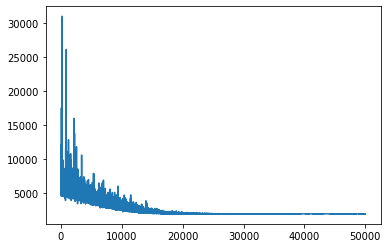

In [823]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [824]:
# samples from the posterior
posterior = approximation.sample(5000)

In [825]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))


MAE =  217812.01585614285
MAPE =  0.34949596728321025


# 8. You could select longitude and latitude to create clusters.

## Clustering

### Full Model

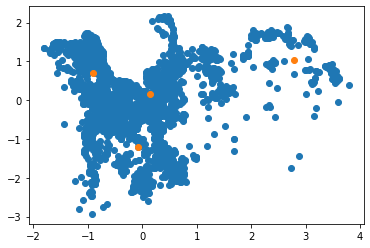

In [826]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)

# Choosing features 4 & 5 which relate to longitude and latitude.
ind=[4,5]

X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])


# 9. Use the number of clusters you model returns.

### Clusters

In [827]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 378, 1: 456, 2: 1036, 3: 119}

In [828]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 78, 1: 99, 2: 231, 3: 36}

In [829]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]
ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [830]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [831]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [832]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

# 10. Apply a model to each cluster.

## Piecewise Model

In [833]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

posterior0 = approximation.sample(5000)

In [834]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 401.52


In [835]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,037.7


In [836]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 194.01


In [837]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred


##Simulations

### Only Cluster 0

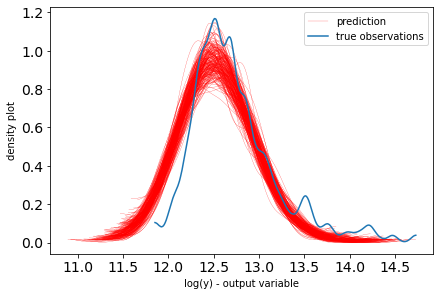

In [838]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

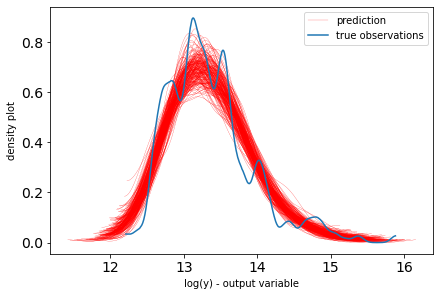

In [839]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

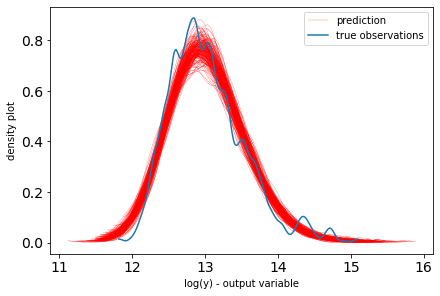

In [840]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

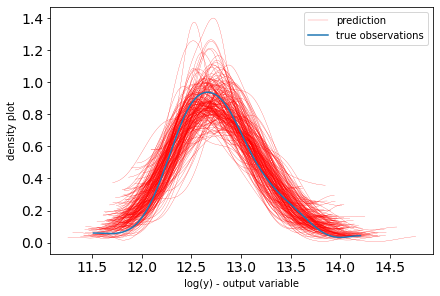

In [841]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

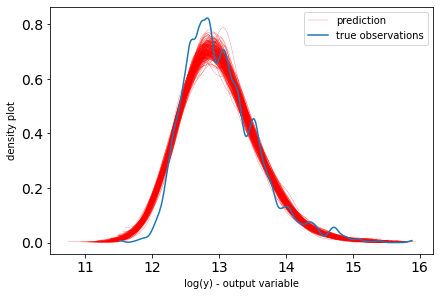

In [842]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [843]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 78 , MAE Cluster0= 110793.2378929251
Size Cluster1 99 , MAE Cluster1= 1412974.725372326
Size Cluster2 231 , MAE Cluster2= 266893.8482510979
Size Cluster3 36 , MAE Cluster3= 33644107458.580612
MAE= 2728373980.5365214


### PPC on the Test set



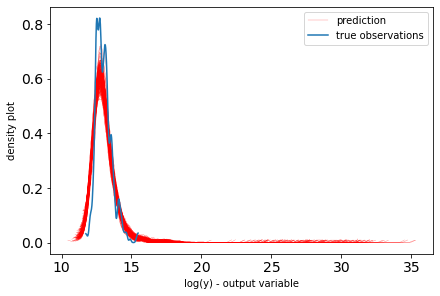

In [844]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY

After analysing the data, I choose the following features:
* area (categorical)
* bathrooms (numeric)
* beds (numeric)
* BER classification (categorical)
* latitude (numeric)
* longitude (numeric)
* property type (categorical)
* surface (numeric)

The following columns were removed for the associated reasons:

* ad id: just an index and does not offer anything useful
* county: there is only one county which is Dublin
* description block: free text, won't give specific details and subjective
* environment: only contains one value
* facility: Free text, won't give specific details and subjective
* features: Free text, won't give specific details and subjective
* no of units: 99.73% of the data was missing
* property category: there was only two values in the training data and one value in the test set

After removing the non-useful columns, I deleted all the rows that contained N/A’s as this was the most straightforward method giving the limited time, I had to implement the solution. I also deleted rows that had zero bedrooms or bathrooms as recommended in the instructions. 

The final step before implement the model was to encode the categorical data. I used a mapper taken from Pathak, (2020) to encode area as there was 144 distinct areas so one-hot encoding did not seem suitable. Courtesy to Mark who implemented for this idea. I used ordinal encoding Saxena, (2020) for BER which worked well and I used one-hot encoding for property type.



### References

Pathak, M. (2020) Handling Categorical Data in Python. Available at: https://www.datacamp.com/community/tutorials/categorical-data (Accessed: 3 October 2021).

Saxena, S. (2020) Here’s All you Need to Know About Encoding Categorical Data (with Python code). Available at: https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/ (Accessed: 1 October 2021).



In [896]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ET5003_Etivity2/ET5003_Etivity2_Stephen_Quirke_20172257.ipynb')
27